# Relative Positional Encoding + Music Transformer Skewing

[Music transformer](https://arxiv.org/pdf/1809.04281.pdf)


In [1]:
import numpy as np
import torch.nn as nn
import torch
import importlib
import pickle
from functools import partial
import matplotlib.pyplot as plt

from src import relative_attention as rpe
from src import torch_models as tm
from src import data
from src import train_utils
from src import utils

In [2]:
def reload_modules():
    importlib.reload(tm)
    importlib.reload(rpe)
    importlib.reload(data)
    importlib.reload(train_utils)
    importlib.reload(utils)

## BBPE

In [3]:
train_path_en = 'data/train.en'
train_path_de = 'data/train.de'
tokenizer_path = "data/tokenizer-bbpe-joint.json"

In [4]:
bbpe = data.get_bbpe_tokenizer(tokenizer_path, data_file_list=[train_path_en, train_path_de])

## model def

In [27]:
reload_modules()
max_context = 64
max_distance = 32
config = rpe.RPEModelConfig(
    dim=512,
    N=8,
    h=8,
    V=bbpe.get_vocab_size(),
    max_context=max_context,
    drop_rate=0.01,
    relative=True,
    per_layer=True,
    use_value_rpe=False,
    max_distance=max_distance,
)
model_krpe_perlayer_skew = rpe.RelativeGPT.from_config(config)

In [28]:
def count_params(model):
    return sum(p.numel() for p in model.parameters())

def print_numel(model, name):
    print(f'{name:>30}: {count_params(model):,}')

Note that the per-layer PE model uses a smaller context and coincidentally ends up with the same number of params as the base model 

In [16]:
print_numel(model_krpe_perlayer_skew, 'per-layer PE with skew')
# key-only per-layer RPE: 55,993,139

        per-layer PE with skew: 55,976,243


## Data Pipelines

In [9]:
if 'train_lines' not in locals():
    train_lines = sum(1 for line in open(data.TRAIN_PATH_EN, encoding='utf-8'))
if 'test_lines' not in locals():
    test_lines = sum(1 for line in open(data.TEST_PATH_EN, encoding='utf-8'))
print(f'train lines: {train_lines}')
print(f'test lines: {test_lines}')

train lines: 4468840
test lines: 2737


### training/ data params

docs: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [10]:
importlib.reload(data)
dataset_config = data.DatasetConfig(bbpe, max_context)
tok_fn = partial(data.str_to_tok, add_start=False)
tok_fn_w_start = partial(data.str_to_tok, add_start=True)

def input_fn(en_line, de_line, data_config):
    en_input = data.str_to_tok(en_line, data_config, add_start=True)
    return [en_input]

def target_fn(en_line, de_line, data_config):
    return data.str_to_tok(en_line, data_config, add_start=False)


In [11]:
# autoregressive training
importlib.reload(data)

batch_size = 64

train_dataset_autoreg = data.WMT2014Mixing(
    num_pools=7919,  # pick a prime number
    start_line=0,
    end_line=train_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=True,
    overwrite_de_path=data.TRAIN_PATH_EN,
)
train_loader_autoreg = torch.utils.data.DataLoader(
    train_dataset_autoreg,
    batch_size=batch_size,
    pin_memory=True,
)

test_dataset_autoreg = data.WMT2014Mixing(
    num_pools=101,  # pick a prime number
    start_line=0,
    end_line=test_lines,
    process_inputs=input_fn,
    process_target=target_fn,
    dataset_config=dataset_config,
    train=False,
    overwrite_de_path=data.TEST_PATH_EN,
)
test_loader_autoreg = torch.utils.data.DataLoader(
    test_dataset_autoreg,
    batch_size=batch_size,
    pin_memory=True,
)

## Training

In [12]:
#loss_histories = dict()
with open('./saved_models/loss_histories.pickle', 'rb') as f:
    loss_histories = pickle.load(f)
with open('./saved_models/loss_histories_bkup.pickle', 'wb') as f:
    pickle.dump(loss_histories, f)
loss_histories.keys()

dict_keys(['mingpt_n2_h8_d512_c64', 'autoreg_n2_h8_d512_c64_wproj_xavier', 'autoreg_n2_h8_d512_c64_wproj_mingptinit', 'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe', 'autoreg_n2_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle', 'autoreg_n8_h8_d512_c64_wproj_mingptinit_learnablepe_shuffle', 'res_n8_h8_d256_c64_wproj_mingptinit_learnablepe_shuffle', 'rpe_konly_n8_h8_d512_c64', 'rpe_konly_perlayer_n8_h8_d512_c64', 'autoreg_n8_h8_d512_c64', 'rpe_kv_perlayer_n8_h8_d512_c64', 'rpe_konly_global_n8_h8_d512_c64', 'rpe_konly_perlayer_n8_h8_d512_c64_v2', 'pe_perlayer_n8_h8_d512_c64'])

In [30]:
key = 'rpe_konly_perlayer_skew_n8_h8_d512_c64_v2'
model = model_krpe_perlayer_skew

_ = model.apply(train_utils.min_gpt_init_weights)
train_utils.train_epoch(
    model,
    loss_histories,
    key,
    'cuda',
    train_loader_autoreg,
    test_loader_autoreg,
    dataset_config,
    save_every=float('inf'),
    eval_every=10000,
    save_state_only=True,
)

  0%|          | 157/69826 [00:57<39:48:34,  2.06s/it]

       10048: training loss 5.727814674377441, test loss 5.896206356758295


  0%|          | 313/69826 [01:56<40:01:51,  2.07s/it]

       20032: training loss 4.889087677001953, test loss 5.16634096101273


  1%|          | 469/69826 [02:53<42:35:44,  2.21s/it]

       30016: training loss 4.718327522277832, test loss 4.820888541465582


  1%|          | 625/69826 [03:51<45:39:39,  2.38s/it]

       40000: training loss 4.295259475708008, test loss 4.646061243012894


  1%|          | 782/69826 [04:48<40:12:43,  2.10s/it]

       50048: training loss 4.27577018737793, test loss 4.528921471085659


  1%|▏         | 938/69826 [05:45<39:53:40,  2.08s/it]

       60032: training loss 4.211437702178955, test loss 4.431851819504139


  2%|▏         | 1094/69826 [06:41<40:12:02,  2.11s/it]

       70016: training loss 4.144989967346191, test loss 4.36605135230131


  2%|▏         | 1250/69826 [07:38<39:42:24,  2.08s/it]

       80000: training loss 4.109028339385986, test loss 4.308094468227653


  2%|▏         | 1407/69826 [08:35<39:47:03,  2.09s/it]

       90048: training loss 4.0265045166015625, test loss 4.271093945170557


  2%|▏         | 1563/69826 [09:32<39:54:30,  2.10s/it]

      100032: training loss 3.964172601699829, test loss 4.230042945506961


  2%|▏         | 1719/69826 [10:28<39:27:49,  2.09s/it]

      110016: training loss 3.752964973449707, test loss 4.200234828993332


  3%|▎         | 1875/69826 [11:24<39:07:17,  2.07s/it]

      120000: training loss 4.05147123336792, test loss 4.161135950753855


  3%|▎         | 2032/69826 [12:21<38:49:57,  2.06s/it]

      130048: training loss 3.8165464401245117, test loss 4.13623188262762


  3%|▎         | 2188/69826 [13:18<38:44:28,  2.06s/it]

      140032: training loss 3.7234063148498535, test loss 4.123438918313314


  3%|▎         | 2344/69826 [14:14<38:40:27,  2.06s/it]

      150016: training loss 3.584164619445801, test loss 4.094466525454854


  4%|▎         | 2500/69826 [15:10<38:47:18,  2.07s/it]

      160000: training loss 3.763683319091797, test loss 4.071765766587368


  4%|▍         | 2657/69826 [16:08<39:16:57,  2.11s/it]

      170048: training loss 3.7666256427764893, test loss 4.0531638001286705


  4%|▍         | 2813/69826 [17:06<44:32:37,  2.39s/it]

      180032: training loss 3.529785394668579, test loss 4.048829710760782


  4%|▍         | 2969/69826 [18:02<38:50:03,  2.09s/it]

      190016: training loss 3.569786548614502, test loss 4.0149981143862705


  4%|▍         | 3125/69826 [18:59<38:22:14,  2.07s/it]

      200000: training loss 3.3961784839630127, test loss 3.993880560231763


  5%|▍         | 3282/69826 [19:55<38:50:39,  2.10s/it]

      210048: training loss 3.5521864891052246, test loss 3.9920277207396753


  5%|▍         | 3438/69826 [20:52<38:43:03,  2.10s/it]

      220032: training loss 3.621865749359131, test loss 3.9685768304869184


  5%|▌         | 3594/69826 [21:50<39:43:32,  2.16s/it]

      230016: training loss 3.5443243980407715, test loss 3.9702996819518335


  5%|▌         | 3750/69826 [22:48<39:50:01,  2.17s/it]

      240000: training loss 3.5074405670166016, test loss 3.944537101789962


  6%|▌         | 3907/69826 [23:46<39:32:42,  2.16s/it]

      250048: training loss 3.446305990219116, test loss 3.9544016705002893


  6%|▌         | 4063/69826 [24:43<39:00:02,  2.13s/it]

      260032: training loss 3.361663341522217, test loss 3.931640026181243


  6%|▌         | 4219/69826 [25:41<39:20:08,  2.16s/it]

      270016: training loss 3.308894395828247, test loss 3.915595376214316


  6%|▋         | 4375/69826 [26:40<44:17:31,  2.44s/it]

      280000: training loss 3.496526002883911, test loss 3.9075615960498187


  6%|▋         | 4532/69826 [27:39<42:07:56,  2.32s/it]

      290048: training loss 3.551832675933838, test loss 3.8969768867936243


  7%|▋         | 4688/69826 [28:37<38:51:11,  2.15s/it]

      300032: training loss 3.3504743576049805, test loss 3.899039007896601


  7%|▋         | 4844/69826 [29:34<39:12:33,  2.17s/it]

      310016: training loss 3.2674849033355713, test loss 3.880716041077015


  7%|▋         | 5000/69826 [30:32<38:36:24,  2.14s/it]

      320000: training loss 3.357046604156494, test loss 3.872518079225407


  7%|▋         | 5157/69826 [31:30<39:01:29,  2.17s/it]

      330048: training loss 3.4817087650299072, test loss 3.8725953434788902


  8%|▊         | 5313/69826 [32:30<38:38:00,  2.16s/it]

      340032: training loss 3.6746575832366943, test loss 3.871489086816477


  8%|▊         | 5469/69826 [33:27<39:05:15,  2.19s/it]

      350016: training loss 3.4619412422180176, test loss 3.8543276398680932


  8%|▊         | 5625/69826 [34:25<39:00:42,  2.19s/it]

      360000: training loss 3.406461238861084, test loss 3.8598134406777316


  8%|▊         | 5782/69826 [35:24<38:54:38,  2.19s/it]

      370048: training loss 3.237543821334839, test loss 3.840041842571525


  9%|▊         | 5938/69826 [36:21<38:45:59,  2.18s/it]

      380032: training loss 3.347060441970825, test loss 3.830158932264461


  9%|▊         | 6094/69826 [37:19<38:41:08,  2.19s/it]

      390016: training loss 3.5753378868103027, test loss 3.8205970997034115


  9%|▉         | 6250/69826 [38:18<39:00:11,  2.21s/it]

      400000: training loss 3.2552709579467773, test loss 3.8288023693617


  9%|▉         | 6407/69826 [39:15<38:47:28,  2.20s/it]

      410048: training loss 3.411587715148926, test loss 3.8180083452269087


  9%|▉         | 6563/69826 [40:14<38:07:17,  2.17s/it]

      420032: training loss 3.4034316539764404, test loss 3.8025571412818375


 10%|▉         | 6719/69826 [41:12<37:51:28,  2.16s/it]

      430016: training loss 3.4352927207946777, test loss 3.784055332804835


 10%|▉         | 6875/69826 [42:09<37:37:01,  2.15s/it]

      440000: training loss 3.238415241241455, test loss 3.790207624435425


 10%|█         | 7032/69826 [43:07<37:37:23,  2.16s/it]

      450048: training loss 3.299973487854004, test loss 3.7949458887410716


 10%|█         | 7188/69826 [44:04<37:20:56,  2.15s/it]

      460032: training loss 3.2510037422180176, test loss 3.782296846079272


 11%|█         | 7344/69826 [45:02<36:38:39,  2.11s/it]

      470016: training loss 3.3174450397491455, test loss 3.781565266986226


 11%|█         | 7500/69826 [46:00<41:54:32,  2.42s/it]

      480000: training loss 3.310204267501831, test loss 3.763070267300273


 11%|█         | 7657/69826 [47:00<41:36:54,  2.41s/it]

      490048: training loss 3.4348809719085693, test loss 3.779272667197294


 11%|█         | 7813/69826 [47:57<36:02:37,  2.09s/it]

      500032: training loss 3.2065110206604004, test loss 3.770979598511097


 11%|█▏        | 7969/69826 [48:55<36:20:33,  2.12s/it]

      510016: training loss 3.1100056171417236, test loss 3.7583066640898237


 12%|█▏        | 8125/69826 [49:53<36:40:38,  2.14s/it]

      520000: training loss 3.2383780479431152, test loss 3.7367810981218206


 12%|█▏        | 8282/69826 [50:50<37:13:47,  2.18s/it]

      530048: training loss 3.227954626083374, test loss 3.7346118106398474


 12%|█▏        | 8438/69826 [51:48<36:29:22,  2.14s/it]

      540032: training loss 3.2283356189727783, test loss 3.7395847786304564


 12%|█▏        | 8594/69826 [52:45<36:12:47,  2.13s/it]

      550016: training loss 3.2298669815063477, test loss 3.7462983796762868


 13%|█▎        | 8750/69826 [53:42<36:47:21,  2.17s/it]

      560000: training loss 3.254549503326416, test loss 3.7384089037429455


 13%|█▎        | 8907/69826 [54:38<35:12:42,  2.08s/it]

      570048: training loss 3.3711254596710205, test loss 3.725150418836017


 13%|█▎        | 9063/69826 [55:35<35:21:07,  2.09s/it]

      580032: training loss 3.117609977722168, test loss 3.7328909607820733


 13%|█▎        | 9219/69826 [56:31<35:01:36,  2.08s/it]

      590016: training loss 3.262134313583374, test loss 3.718311847642411


 13%|█▎        | 9375/69826 [57:29<34:59:00,  2.08s/it]

      600000: training loss 3.0821824073791504, test loss 3.7144704197728355


 14%|█▎        | 9532/69826 [58:25<34:41:31,  2.07s/it]

      610048: training loss 3.154158592224121, test loss 3.7206767991531726


 14%|█▍        | 9688/69826 [59:22<39:55:42,  2.39s/it]

      620032: training loss 3.023805618286133, test loss 3.7009070141370906


 14%|█▍        | 9844/69826 [1:00:19<34:44:08,  2.08s/it]

      630016: training loss 3.2354729175567627, test loss 3.7094165558038754


 14%|█▍        | 10000/69826 [1:01:16<34:41:14,  2.09s/it]

      640000: training loss 3.3923141956329346, test loss 3.7106389722158744


 15%|█▍        | 10157/69826 [1:02:14<40:10:50,  2.42s/it]

      650048: training loss 3.198352098464966, test loss 3.69671256597652


 15%|█▍        | 10313/69826 [1:03:11<34:38:23,  2.10s/it]

      660032: training loss 3.236093521118164, test loss 3.7048908222553343


 15%|█▍        | 10469/69826 [1:04:07<34:34:59,  2.10s/it]

      670016: training loss 3.0992038249969482, test loss 3.6983783577763756


 15%|█▌        | 10625/69826 [1:05:04<34:08:44,  2.08s/it]

      680000: training loss 3.142428398132324, test loss 3.691638148108194


 15%|█▌        | 10782/69826 [1:06:00<34:25:38,  2.10s/it]

      690048: training loss 3.2057809829711914, test loss 3.696442825849666


 16%|█▌        | 10938/69826 [1:06:57<34:15:24,  2.09s/it]

      700032: training loss 3.029517412185669, test loss 3.6899885854055716


 16%|█▌        | 11094/69826 [1:07:53<34:10:44,  2.10s/it]

      710016: training loss 3.2431180477142334, test loss 3.675647779952648


 16%|█▌        | 11250/69826 [1:08:50<34:27:46,  2.12s/it]

      720000: training loss 3.020259380340576, test loss 3.6816304118134253


 16%|█▋        | 11407/69826 [1:09:47<33:56:51,  2.09s/it]

      730048: training loss 3.0833473205566406, test loss 3.669387695401214


 17%|█▋        | 11563/69826 [1:10:43<33:36:59,  2.08s/it]

      740032: training loss 3.1996536254882812, test loss 3.656350900960523


 17%|█▋        | 11719/69826 [1:11:40<34:32:25,  2.14s/it]

      750016: training loss 3.091733932495117, test loss 3.6585217409355697


 17%|█▋        | 11875/69826 [1:12:37<34:12:54,  2.13s/it]

      760000: training loss 3.05147123336792, test loss 3.6751825975817303


 17%|█▋        | 12032/69826 [1:13:35<34:25:03,  2.14s/it]

      770048: training loss 3.3447535037994385, test loss 3.666246214578318


 17%|█▋        | 12188/69826 [1:14:32<33:49:34,  2.11s/it]

      780032: training loss 3.2007012367248535, test loss 3.6486270372257676


 18%|█▊        | 12344/69826 [1:15:29<33:44:04,  2.11s/it]

      790016: training loss 3.210629940032959, test loss 3.644316834072734


 18%|█▊        | 12500/69826 [1:16:26<33:46:59,  2.12s/it]

      800000: training loss 3.326294422149658, test loss 3.6488531301187916


 18%|█▊        | 12657/69826 [1:17:23<33:30:24,  2.11s/it]

      810048: training loss 3.105229139328003, test loss 3.645067259322765


 18%|█▊        | 12813/69826 [1:18:20<35:31:16,  2.24s/it]

      820032: training loss 3.2118897438049316, test loss 3.638710321382035


 19%|█▊        | 12969/69826 [1:19:17<33:32:31,  2.12s/it]

      830016: training loss 3.0760037899017334, test loss 3.6386011256728064


 19%|█▉        | 13125/69826 [1:20:14<33:38:30,  2.14s/it]

      840000: training loss 3.2559902667999268, test loss 3.636581359907638


 19%|█▉        | 13282/69826 [1:21:14<33:34:00,  2.14s/it]

      850048: training loss 3.292325019836426, test loss 3.6331884472869165


 19%|█▉        | 13438/69826 [1:22:11<33:36:23,  2.15s/it]

      860032: training loss 3.0151126384735107, test loss 3.636677769727485


 19%|█▉        | 13594/69826 [1:23:08<33:43:17,  2.16s/it]

      870016: training loss 3.202970027923584, test loss 3.6428061529647473


 20%|█▉        | 13750/69826 [1:24:07<33:18:38,  2.14s/it]

      880000: training loss 3.0397579669952393, test loss 3.629121835841689


 20%|█▉        | 13907/69826 [1:25:05<32:49:08,  2.11s/it]

      890048: training loss 3.041015863418579, test loss 3.6406212684720063


 20%|██        | 14063/69826 [1:26:03<37:23:56,  2.41s/it]

      900032: training loss 3.106233835220337, test loss 3.6337115598279377


 20%|██        | 14219/69826 [1:27:01<33:09:39,  2.15s/it]

      910016: training loss 3.1515049934387207, test loss 3.627785849016766


 21%|██        | 14375/69826 [1:27:58<33:25:09,  2.17s/it]

      920000: training loss 3.2223525047302246, test loss 3.62369135368702


 21%|██        | 14532/69826 [1:29:00<37:10:35,  2.42s/it]

      930048: training loss 2.969034433364868, test loss 3.619038376697274


 21%|██        | 14688/69826 [1:30:01<37:20:41,  2.44s/it]

      940032: training loss 3.2577462196350098, test loss 3.6231988696164863


 21%|██▏       | 14844/69826 [1:31:00<36:57:52,  2.42s/it]

      950016: training loss 3.070162773132324, test loss 3.6119729474533435


 21%|██▏       | 15000/69826 [1:31:58<32:27:55,  2.13s/it]

      960000: training loss 3.28588604927063, test loss 3.6100777193557385


 22%|██▏       | 15157/69826 [1:32:56<32:36:00,  2.15s/it]

      970048: training loss 2.9875476360321045, test loss 3.6130986380022625


 22%|██▏       | 15313/69826 [1:33:53<32:26:36,  2.14s/it]

      980032: training loss 3.116720199584961, test loss 3.5995937835338503


 22%|██▏       | 15469/69826 [1:34:51<32:26:51,  2.15s/it]

      990016: training loss 3.0222091674804688, test loss 3.60655907142994


 22%|██▏       | 15625/69826 [1:35:48<32:16:50,  2.14s/it]

     1000000: training loss 3.165846109390259, test loss 3.602336428886236


 23%|██▎       | 15782/69826 [1:36:46<32:19:55,  2.15s/it]

     1010048: training loss 2.91562819480896, test loss 3.603956616202066


 23%|██▎       | 15938/69826 [1:37:42<31:45:24,  2.12s/it]

     1020032: training loss 3.097519874572754, test loss 3.6074994719305704


 23%|██▎       | 16094/69826 [1:38:39<31:03:21,  2.08s/it]

     1030016: training loss 3.0753912925720215, test loss 3.589092648306558


 23%|██▎       | 16250/69826 [1:39:37<32:17:17,  2.17s/it]

     1040000: training loss 3.2531321048736572, test loss 3.594165020210798


 23%|██▎       | 16407/69826 [1:40:34<31:07:23,  2.10s/it]

     1050048: training loss 3.089094400405884, test loss 3.6005188531653824


 24%|██▎       | 16563/69826 [1:41:31<31:46:01,  2.15s/it]

     1060032: training loss 3.1567060947418213, test loss 3.579771174940952


 24%|██▍       | 16719/69826 [1:42:30<35:26:05,  2.40s/it]

     1070016: training loss 3.117192268371582, test loss 3.5848654259082884


 24%|██▍       | 16875/69826 [1:43:29<31:27:21,  2.14s/it]

     1080000: training loss 3.180440664291382, test loss 3.5893830365912858


 24%|██▍       | 17032/69826 [1:44:27<33:35:28,  2.29s/it]

     1090048: training loss 2.833850860595703, test loss 3.5852302007896957


 25%|██▍       | 17188/69826 [1:45:28<35:08:58,  2.40s/it]

     1100032: training loss 3.0601389408111572, test loss 3.583384170088657


 25%|██▍       | 17344/69826 [1:46:26<31:18:28,  2.15s/it]

     1110016: training loss 3.0571582317352295, test loss 3.591637927432393


 25%|██▌       | 17500/69826 [1:47:25<31:08:47,  2.14s/it]

     1120000: training loss 3.165274143218994, test loss 3.5747150931247447


 25%|██▌       | 17657/69826 [1:48:23<31:11:59,  2.15s/it]

     1130048: training loss 2.9862616062164307, test loss 3.5915015797282375


 26%|██▌       | 17813/69826 [1:49:21<30:57:00,  2.14s/it]

     1140032: training loss 3.210970401763916, test loss 3.581633346025334


 26%|██▌       | 17969/69826 [1:50:18<30:54:30,  2.15s/it]

     1150016: training loss 3.0123543739318848, test loss 3.5742706919825356


 26%|██▌       | 18125/69826 [1:51:15<30:49:46,  2.15s/it]

     1160000: training loss 3.09464430809021, test loss 3.564749318499898


 26%|██▌       | 18282/69826 [1:52:13<30:29:52,  2.13s/it]

     1170048: training loss 3.0571813583374023, test loss 3.5746911736421807


 26%|██▋       | 18438/69826 [1:53:10<30:31:03,  2.14s/it]

     1180032: training loss 3.107572078704834, test loss 3.568459943283436


 27%|██▋       | 18594/69826 [1:54:07<30:09:29,  2.12s/it]

     1190016: training loss 2.8714733123779297, test loss 3.564175156659858


 27%|██▋       | 18750/69826 [1:55:05<30:01:29,  2.12s/it]

     1200000: training loss 2.8364064693450928, test loss 3.5631130906038506


 27%|██▋       | 18907/69826 [1:56:02<29:41:09,  2.10s/it]

     1210048: training loss 3.0069730281829834, test loss 3.550557175347971


 27%|██▋       | 19063/69826 [1:56:59<29:54:29,  2.12s/it]

     1220032: training loss 2.8796472549438477, test loss 3.554625289384709


 28%|██▊       | 19219/69826 [1:57:56<29:45:50,  2.12s/it]

     1230016: training loss 3.0887374877929688, test loss 3.56419477906338


 28%|██▊       | 19375/69826 [1:58:53<29:24:43,  2.10s/it]

     1240000: training loss 3.1435227394104004, test loss 3.5551570071730505


 28%|██▊       | 19532/69826 [1:59:50<29:23:01,  2.10s/it]

     1250048: training loss 3.0351555347442627, test loss 3.555771267691324


 28%|██▊       | 19688/69826 [2:00:47<29:11:48,  2.10s/it]

     1260032: training loss 2.848238945007324, test loss 3.5399957645771116


 28%|██▊       | 19844/69826 [2:01:44<33:14:29,  2.39s/it]

     1270016: training loss 2.991647958755493, test loss 3.554459854613903


 29%|██▊       | 20000/69826 [2:02:41<29:11:32,  2.11s/it]

     1280000: training loss 2.8801372051239014, test loss 3.565996208856272


 29%|██▉       | 20157/69826 [2:03:38<28:55:32,  2.10s/it]

     1290048: training loss 2.985764741897583, test loss 3.5409864436748415


 29%|██▉       | 20313/69826 [2:04:35<28:58:23,  2.11s/it]

     1300032: training loss 3.1925487518310547, test loss 3.5537748004114906


 29%|██▉       | 20469/69826 [2:05:32<28:48:47,  2.10s/it]

     1310016: training loss 2.8856496810913086, test loss 3.5491892237995946


 30%|██▉       | 20625/69826 [2:06:29<28:30:23,  2.09s/it]

     1320000: training loss 3.0611183643341064, test loss 3.5374374167863714


 30%|██▉       | 20782/69826 [2:07:26<28:40:36,  2.10s/it]

     1330048: training loss 2.9973795413970947, test loss 3.5377271508061607


 30%|██▉       | 20938/69826 [2:08:23<28:31:05,  2.10s/it]

     1340032: training loss 3.1615068912506104, test loss 3.551530350086301


 30%|███       | 21094/69826 [2:09:20<30:38:53,  2.26s/it]

     1350016: training loss 3.343226909637451, test loss 3.5314825745516045


 30%|███       | 21250/69826 [2:10:17<28:22:51,  2.10s/it]

     1360000: training loss 3.234950304031372, test loss 3.539492407510447


 31%|███       | 21407/69826 [2:11:15<28:46:30,  2.14s/it]

     1370048: training loss 3.0336451530456543, test loss 3.536765464516573


 31%|███       | 21563/69826 [2:12:12<28:33:48,  2.13s/it]

     1380032: training loss 2.851644992828369, test loss 3.5282099468763484


 31%|███       | 21719/69826 [2:13:09<28:21:54,  2.12s/it]

     1390016: training loss 2.904101610183716, test loss 3.528614509937375


 31%|███▏      | 21875/69826 [2:14:06<28:28:36,  2.14s/it]

     1400000: training loss 2.9828481674194336, test loss 3.5281752763792524


 32%|███▏      | 22032/69826 [2:15:03<28:11:09,  2.12s/it]

     1410048: training loss 2.8735907077789307, test loss 3.517804744631745


 32%|███▏      | 22188/69826 [2:16:00<28:13:24,  2.13s/it]

     1420032: training loss 2.9713780879974365, test loss 3.5265388156092445


 32%|███▏      | 22344/69826 [2:16:58<27:41:09,  2.10s/it]

     1430016: training loss 3.250516176223755, test loss 3.5277894264043765


 32%|███▏      | 22500/69826 [2:17:55<28:00:56,  2.13s/it]

     1440000: training loss 3.0423974990844727, test loss 3.512719841890557


 32%|███▏      | 22657/69826 [2:18:53<27:47:23,  2.12s/it]

     1450048: training loss 3.0112903118133545, test loss 3.525775804076084


 33%|███▎      | 22813/69826 [2:19:49<27:28:51,  2.10s/it]

     1460032: training loss 3.21117901802063, test loss 3.5151299044143323


 33%|███▎      | 22969/69826 [2:20:47<31:20:19,  2.41s/it]

     1470016: training loss 3.075620174407959, test loss 3.5253988864809966


 33%|███▎      | 23125/69826 [2:21:44<27:16:02,  2.10s/it]

     1480000: training loss 2.9567596912384033, test loss 3.5097393767778264


 33%|███▎      | 23282/69826 [2:22:42<27:06:37,  2.10s/it]

     1490048: training loss 3.1287057399749756, test loss 3.5219195942546047


 34%|███▎      | 23438/69826 [2:23:40<31:03:19,  2.41s/it]

     1500032: training loss 2.849025011062622, test loss 3.5137363977210465


 34%|███▍      | 23594/69826 [2:24:38<26:52:53,  2.09s/it]

     1510016: training loss 3.074655532836914, test loss 3.5287781870642374


 34%|███▍      | 23750/69826 [2:25:36<27:10:59,  2.12s/it]

     1520000: training loss 2.9198551177978516, test loss 3.5198483245317327


 34%|███▍      | 23907/69826 [2:26:33<26:49:30,  2.10s/it]

     1530048: training loss 3.0690343379974365, test loss 3.5147151836129122


 34%|███▍      | 24063/69826 [2:27:31<30:45:32,  2.42s/it]

     1540032: training loss 2.911492347717285, test loss 3.5190354557924493


 35%|███▍      | 24219/69826 [2:28:27<26:42:27,  2.11s/it]

     1550016: training loss 3.1759586334228516, test loss 3.5061101858005967


 35%|███▍      | 24375/69826 [2:29:25<26:39:30,  2.11s/it]

     1560000: training loss 2.9095044136047363, test loss 3.505231679872025


 35%|███▌      | 24532/69826 [2:30:22<26:33:44,  2.11s/it]

     1570048: training loss 2.966357946395874, test loss 3.498887383660605


 35%|███▌      | 24688/69826 [2:31:19<26:25:50,  2.11s/it]

     1580032: training loss 3.0208382606506348, test loss 3.514489445575448


 36%|███▌      | 24844/69826 [2:32:16<26:29:29,  2.12s/it]

     1590016: training loss 3.0071446895599365, test loss 3.511962275172389


 36%|███▌      | 25000/69826 [2:33:13<26:04:53,  2.09s/it]

     1600000: training loss 3.089186191558838, test loss 3.510234084240226


 36%|███▌      | 25157/69826 [2:34:10<26:03:21,  2.10s/it]

     1610048: training loss 2.848262310028076, test loss 3.511758704518163


 36%|███▋      | 25313/69826 [2:35:07<27:40:43,  2.24s/it]

     1620032: training loss 3.1015820503234863, test loss 3.506246566772461


 36%|███▋      | 25469/69826 [2:36:04<25:53:24,  2.10s/it]

     1630016: training loss 2.9008114337921143, test loss 3.4960116951964624


 37%|███▋      | 25625/69826 [2:37:01<26:08:24,  2.13s/it]

     1640000: training loss 2.8965611457824707, test loss 3.492125688597213


 37%|███▋      | 25782/69826 [2:37:58<25:59:03,  2.12s/it]

     1650048: training loss 2.9945285320281982, test loss 3.5074008398277816


 37%|███▋      | 25938/69826 [2:38:55<25:36:58,  2.10s/it]

     1660032: training loss 2.9719042778015137, test loss 3.50124808244927


 37%|███▋      | 26094/69826 [2:39:52<25:33:24,  2.10s/it]

     1670016: training loss 2.7928593158721924, test loss 3.5050098674241887


 38%|███▊      | 26250/69826 [2:40:49<25:15:36,  2.09s/it]

     1680000: training loss 3.042524576187134, test loss 3.498733681301738


 38%|███▊      | 26407/69826 [2:41:46<25:31:31,  2.12s/it]

     1690048: training loss 2.9889180660247803, test loss 3.4959330392438313


 38%|███▊      | 26563/69826 [2:42:42<25:17:42,  2.10s/it]

     1700032: training loss 3.280315399169922, test loss 3.4993042890415635


 38%|███▊      | 26719/69826 [2:43:39<25:09:18,  2.10s/it]

     1710016: training loss 3.0322282314300537, test loss 3.488003514533819


 38%|███▊      | 26875/69826 [2:44:36<25:07:22,  2.11s/it]

     1720000: training loss 2.9062435626983643, test loss 3.495237161946851


 39%|███▊      | 27032/69826 [2:45:33<24:48:23,  2.09s/it]

     1730048: training loss 3.104832649230957, test loss 3.4933061710623807


 39%|███▉      | 27188/69826 [2:46:30<24:56:21,  2.11s/it]

     1740032: training loss 2.59812331199646, test loss 3.486130409462507


 39%|███▉      | 27344/69826 [2:47:26<24:46:13,  2.10s/it]

     1750016: training loss 2.93906569480896, test loss 3.485006254772807


 39%|███▉      | 27500/69826 [2:48:23<24:49:53,  2.11s/it]

     1760000: training loss 3.1815741062164307, test loss 3.500122613685076


 40%|███▉      | 27657/69826 [2:49:21<27:57:09,  2.39s/it]

     1770048: training loss 2.785553455352783, test loss 3.487586880839148


 40%|███▉      | 27813/69826 [2:50:19<24:59:46,  2.14s/it]

     1780032: training loss 2.9290807247161865, test loss 3.4925381194713503


 40%|████      | 27969/69826 [2:51:16<27:50:28,  2.39s/it]

     1790016: training loss 3.009098529815674, test loss 3.4904595641202705


 40%|████      | 28125/69826 [2:52:14<24:07:58,  2.08s/it]

     1800000: training loss 2.9928343296051025, test loss 3.4903749310693075


 41%|████      | 28282/69826 [2:53:11<24:04:38,  2.09s/it]

     1810048: training loss 2.9591104984283447, test loss 3.4768937798433526


 41%|████      | 28438/69826 [2:54:09<27:25:41,  2.39s/it]

     1820032: training loss 3.0138304233551025, test loss 3.4791251005128374


 41%|████      | 28594/69826 [2:55:06<24:22:13,  2.13s/it]

     1830016: training loss 2.971219778060913, test loss 3.4614156068757524


 41%|████      | 28750/69826 [2:56:02<23:59:29,  2.10s/it]

     1840000: training loss 2.9898858070373535, test loss 3.481996924378151


 41%|████▏     | 28907/69826 [2:57:00<23:58:01,  2.11s/it]

     1850048: training loss 2.907649278640747, test loss 3.468907267548317


 42%|████▏     | 29063/69826 [2:57:58<23:45:36,  2.10s/it]

     1860032: training loss 2.939354419708252, test loss 3.477207206016363


 42%|████▏     | 29219/69826 [2:58:54<23:34:43,  2.09s/it]

     1870016: training loss 3.0360488891601562, test loss 3.4835034082102223


 42%|████▏     | 29375/69826 [2:59:53<29:22:23,  2.61s/it]

     1880000: training loss 3.003568410873413, test loss 3.4829763090887735


 42%|████▏     | 29532/69826 [3:00:51<23:36:55,  2.11s/it]

     1890048: training loss 3.0717263221740723, test loss 3.467265544935714


 43%|████▎     | 29688/69826 [3:01:48<23:16:50,  2.09s/it]

     1900032: training loss 2.9853055477142334, test loss 3.470308597697768


 43%|████▎     | 29844/69826 [3:02:45<23:20:27,  2.10s/it]

     1910016: training loss 3.081301689147949, test loss 3.4900315306907475


 43%|████▎     | 30000/69826 [3:03:42<23:17:14,  2.11s/it]

     1920000: training loss 2.9257254600524902, test loss 3.483023920724558


 43%|████▎     | 30157/69826 [3:04:39<23:14:35,  2.11s/it]

     1930048: training loss 3.0543367862701416, test loss 3.4692241868307425


 43%|████▎     | 30313/69826 [3:05:36<23:14:18,  2.12s/it]

     1940032: training loss 2.808626413345337, test loss 3.466856779054154


 44%|████▎     | 30469/69826 [3:06:33<23:01:44,  2.11s/it]

     1950016: training loss 2.7026031017303467, test loss 3.4719986305680384


 44%|████▍     | 30625/69826 [3:07:29<22:34:44,  2.07s/it]

     1960000: training loss 2.8770251274108887, test loss 3.467091260954391


 44%|████▍     | 30782/69826 [3:08:26<22:32:12,  2.08s/it]

     1970048: training loss 2.9353814125061035, test loss 3.4669223386187884


 44%|████▍     | 30938/69826 [3:09:24<25:47:38,  2.39s/it]

     1980032: training loss 2.9261131286621094, test loss 3.4670879120050473


 45%|████▍     | 31094/69826 [3:10:21<22:27:43,  2.09s/it]

     1990016: training loss 2.678117513656616, test loss 3.455125464949497


 45%|████▍     | 31250/69826 [3:11:18<22:36:16,  2.11s/it]

     2000000: training loss 2.967862844467163, test loss 3.456587702728981


 45%|████▍     | 31407/69826 [3:12:14<22:24:00,  2.10s/it]

     2010048: training loss 3.0293405055999756, test loss 3.4565549229466637


 45%|████▌     | 31563/69826 [3:13:11<22:23:57,  2.11s/it]

     2020032: training loss 2.7738521099090576, test loss 3.463520371636679


 45%|████▌     | 31719/69826 [3:14:08<22:25:10,  2.12s/it]

     2030016: training loss 2.8925201892852783, test loss 3.455721195354018


 46%|████▌     | 31875/69826 [3:15:06<22:14:05,  2.11s/it]

     2040000: training loss 2.7538907527923584, test loss 3.4560228946597076


 46%|████▌     | 32032/69826 [3:16:03<22:26:16,  2.14s/it]

     2050048: training loss 2.990262746810913, test loss 3.455219961876093


 46%|████▌     | 32188/69826 [3:17:00<22:00:50,  2.11s/it]

     2060032: training loss 3.1286427974700928, test loss 3.457535361134729


 46%|████▋     | 32344/69826 [3:17:57<21:56:02,  2.11s/it]

     2070016: training loss 2.9665093421936035, test loss 3.455969056417776


 47%|████▋     | 32500/69826 [3:18:56<21:57:11,  2.12s/it]

     2080000: training loss 2.7996788024902344, test loss 3.457575188126675


 47%|████▋     | 32657/69826 [3:19:54<21:56:27,  2.13s/it]

     2090048: training loss 2.9790399074554443, test loss 3.4545829684235327


 47%|████▋     | 32813/69826 [3:20:51<21:47:57,  2.12s/it]

     2100032: training loss 2.8564646244049072, test loss 3.451906365017558


 47%|████▋     | 32969/69826 [3:21:49<21:36:51,  2.11s/it]

     2110016: training loss 2.99399471282959, test loss 3.456798037817312


 47%|████▋     | 33125/69826 [3:22:46<21:14:11,  2.08s/it]

     2120000: training loss 2.9590859413146973, test loss 3.4426395948543105


 48%|████▊     | 33282/69826 [3:23:43<21:10:26,  2.09s/it]

     2130048: training loss 3.191654682159424, test loss 3.460595175277355


 48%|████▊     | 33438/69826 [3:24:39<21:03:30,  2.08s/it]

     2140032: training loss 2.9238181114196777, test loss 3.4636931862942006


 48%|████▊     | 33594/69826 [3:25:36<22:13:51,  2.21s/it]

     2150016: training loss 2.8300158977508545, test loss 3.4598058378973673


 48%|████▊     | 33750/69826 [3:26:33<20:52:05,  2.08s/it]

     2160000: training loss 2.9301798343658447, test loss 3.4617306132649266


 49%|████▊     | 33907/69826 [3:27:30<20:52:51,  2.09s/it]

     2170048: training loss 3.070007801055908, test loss 3.4539977561595827


 49%|████▉     | 34063/69826 [3:28:28<20:58:40,  2.11s/it]

     2180032: training loss 2.768768548965454, test loss 3.4654402400172035


 49%|████▉     | 34219/69826 [3:29:24<20:31:52,  2.08s/it]

     2190016: training loss 2.979872465133667, test loss 3.45255623307339


 49%|████▉     | 34375/69826 [3:30:22<20:59:21,  2.13s/it]

     2200000: training loss 2.8745009899139404, test loss 3.445935604184173


 49%|████▉     | 34532/69826 [3:31:20<20:33:54,  2.10s/it]

     2210048: training loss 2.852998733520508, test loss 3.445385672325312


 50%|████▉     | 34688/69826 [3:32:18<20:53:26,  2.14s/it]

     2220032: training loss 2.892712354660034, test loss 3.439631168232408


 50%|████▉     | 34844/69826 [3:33:15<20:25:13,  2.10s/it]

     2230016: training loss 2.999821186065674, test loss 3.4419986647228864


 50%|█████     | 35000/69826 [3:34:12<20:13:17,  2.09s/it]

     2240000: training loss 2.9175498485565186, test loss 3.4394516002300173


 50%|█████     | 35157/69826 [3:35:08<20:07:49,  2.09s/it]

     2250048: training loss 2.8411338329315186, test loss 3.4376434559045834


 51%|█████     | 35313/69826 [3:36:05<20:12:39,  2.11s/it]

     2260032: training loss 3.0464446544647217, test loss 3.4335593456445737


 51%|█████     | 35469/69826 [3:37:03<19:58:36,  2.09s/it]

     2270016: training loss 2.8881237506866455, test loss 3.431694424429605


 51%|█████     | 35625/69826 [3:38:00<19:52:50,  2.09s/it]

     2280000: training loss 2.7558276653289795, test loss 3.4422859258429948


 51%|█████     | 35782/69826 [3:38:58<19:59:32,  2.11s/it]

     2290048: training loss 2.999652147293091, test loss 3.435403868209484


 51%|█████▏    | 35938/69826 [3:39:56<22:24:42,  2.38s/it]

     2300032: training loss 2.7998881340026855, test loss 3.4394873741061187


 52%|█████▏    | 36094/69826 [3:40:53<20:13:28,  2.16s/it]

     2310016: training loss 2.996596574783325, test loss 3.432585411293562


 52%|█████▏    | 36250/69826 [3:41:50<19:29:49,  2.09s/it]

     2320000: training loss 2.87957501411438, test loss 3.429750592209572


 52%|█████▏    | 36407/69826 [3:42:47<19:13:21,  2.07s/it]

     2330048: training loss 2.705270290374756, test loss 3.4409604737924977


 52%|█████▏    | 36563/69826 [3:43:44<19:21:47,  2.10s/it]

     2340032: training loss 2.810542106628418, test loss 3.4299415821252865


 53%|█████▎    | 36719/69826 [3:44:40<19:19:21,  2.10s/it]

     2350016: training loss 2.881161689758301, test loss 3.4342651588972224


 53%|█████▎    | 36875/69826 [3:45:37<19:01:19,  2.08s/it]

     2360000: training loss 2.9252424240112305, test loss 3.4278986897579458


 53%|█████▎    | 37032/69826 [3:46:34<18:55:03,  2.08s/it]

     2370048: training loss 2.7858104705810547, test loss 3.426235792248748


 53%|█████▎    | 37188/69826 [3:47:30<18:46:52,  2.07s/it]

     2380032: training loss 2.872204303741455, test loss 3.4332173535990163


 53%|█████▎    | 37344/69826 [3:48:26<18:47:11,  2.08s/it]

     2390016: training loss 2.704819679260254, test loss 3.428864517877268


 54%|█████▎    | 37500/69826 [3:49:22<18:37:53,  2.07s/it]

     2400000: training loss 2.9307703971862793, test loss 3.4278615186380788


 54%|█████▍    | 37657/69826 [3:50:20<19:46:16,  2.21s/it]

     2410048: training loss 2.947007656097412, test loss 3.42999344093855


 54%|█████▍    | 37813/69826 [3:51:16<18:35:58,  2.09s/it]

     2420032: training loss 2.895498514175415, test loss 3.430518438649732


 54%|█████▍    | 37969/69826 [3:52:13<18:26:51,  2.08s/it]

     2430016: training loss 2.8167169094085693, test loss 3.425064203351043


 55%|█████▍    | 38125/69826 [3:53:09<18:20:46,  2.08s/it]

     2440000: training loss 2.7548043727874756, test loss 3.4362825903781626


 55%|█████▍    | 38282/69826 [3:54:08<21:03:53,  2.40s/it]

     2450048: training loss 2.713181972503662, test loss 3.428740922794786


 55%|█████▌    | 38438/69826 [3:55:05<18:14:57,  2.09s/it]

     2460032: training loss 3.0611135959625244, test loss 3.4241509548453397


 55%|█████▌    | 38594/69826 [3:56:02<18:10:50,  2.10s/it]

     2470016: training loss 3.033036708831787, test loss 3.4231434422870013


 55%|█████▌    | 38750/69826 [3:56:59<18:23:58,  2.13s/it]

     2480000: training loss 3.0016767978668213, test loss 3.4251840558162954


 56%|█████▌    | 38907/69826 [3:57:56<18:16:43,  2.13s/it]

     2490048: training loss 2.8886961936950684, test loss 3.432860014050506


 56%|█████▌    | 39063/69826 [3:58:54<18:13:28,  2.13s/it]

     2500032: training loss 2.8923778533935547, test loss 3.4263970907344374


 56%|█████▌    | 39219/69826 [3:59:51<18:20:02,  2.16s/it]

     2510016: training loss 2.692203998565674, test loss 3.426950299462607


 56%|█████▋    | 39375/69826 [4:00:48<17:59:48,  2.13s/it]

     2520000: training loss 2.8508994579315186, test loss 3.425994324129681


 57%|█████▋    | 39532/69826 [4:01:45<17:53:24,  2.13s/it]

     2530048: training loss 2.9777398109436035, test loss 3.414623121882594


 57%|█████▋    | 39688/69826 [4:02:42<17:25:40,  2.08s/it]

     2540032: training loss 2.9325132369995117, test loss 3.4223101139068604


 57%|█████▋    | 39844/69826 [4:03:38<17:25:18,  2.09s/it]

     2550016: training loss 2.8802731037139893, test loss 3.427814993747445


 57%|█████▋    | 40000/69826 [4:04:35<17:15:41,  2.08s/it]

     2560000: training loss 2.790881633758545, test loss 3.4306086606757584


 58%|█████▊    | 40157/69826 [4:05:32<17:09:53,  2.08s/it]

     2570048: training loss 2.7752699851989746, test loss 3.4196137383926746


 58%|█████▊    | 40313/69826 [4:06:29<17:12:24,  2.10s/it]

     2580032: training loss 2.8919599056243896, test loss 3.4200854246006456


 58%|█████▊    | 40469/69826 [4:07:26<17:12:18,  2.11s/it]

     2590016: training loss 2.79630184173584, test loss 3.419745500697646


 58%|█████▊    | 40625/69826 [4:08:22<17:10:40,  2.12s/it]

     2600000: training loss 2.83188533782959, test loss 3.4183403724847836


 58%|█████▊    | 40782/69826 [4:09:21<19:25:16,  2.41s/it]

     2610048: training loss 2.9322383403778076, test loss 3.421412567759669


 59%|█████▊    | 40938/69826 [4:10:18<16:49:39,  2.10s/it]

     2620032: training loss 2.8270256519317627, test loss 3.418810955313749


 59%|█████▉    | 41094/69826 [4:11:15<16:37:55,  2.08s/it]

     2630016: training loss 2.8538081645965576, test loss 3.4145207127859427


 59%|█████▉    | 41250/69826 [4:12:12<16:41:46,  2.10s/it]

     2640000: training loss 2.9365131855010986, test loss 3.4071616405664487


 59%|█████▉    | 41407/69826 [4:13:09<16:43:35,  2.12s/it]

     2650048: training loss 2.881063461303711, test loss 3.4147414551224817


 60%|█████▉    | 41563/69826 [4:14:05<16:34:47,  2.11s/it]

     2660032: training loss 2.97584867477417, test loss 3.405200952707335


 60%|█████▉    | 41719/69826 [4:15:03<18:39:30,  2.39s/it]

     2670016: training loss 2.860342025756836, test loss 3.420117361601009


 60%|█████▉    | 41875/69826 [4:16:01<17:15:32,  2.22s/it]

     2680000: training loss 3.1960718631744385, test loss 3.4034001383670542


 60%|██████    | 42032/69826 [4:16:58<16:15:35,  2.11s/it]

     2690048: training loss 2.771479606628418, test loss 3.4068223265714423


 60%|██████    | 42188/69826 [4:17:56<18:24:01,  2.40s/it]

     2700032: training loss 2.7940242290496826, test loss 3.4077927733576576


 61%|██████    | 42344/69826 [4:18:54<18:18:33,  2.40s/it]

     2710016: training loss 2.9397525787353516, test loss 3.4029116907785104


 61%|██████    | 42500/69826 [4:19:53<18:18:55,  2.41s/it]

     2720000: training loss 2.9960081577301025, test loss 3.406217015066812


 61%|██████    | 42657/69826 [4:20:51<16:00:56,  2.12s/it]

     2730048: training loss 2.856689691543579, test loss 3.399883591851523


 61%|██████▏   | 42813/69826 [4:21:48<15:59:20,  2.13s/it]

     2740032: training loss 2.9828598499298096, test loss 3.3887136315190514


 62%|██████▏   | 42969/69826 [4:22:46<17:47:36,  2.39s/it]

     2750016: training loss 2.949659824371338, test loss 3.401181237642155


 62%|██████▏   | 43125/69826 [4:23:42<15:32:09,  2.09s/it]

     2760000: training loss 2.715517520904541, test loss 3.4024687090585397


 62%|██████▏   | 43282/69826 [4:24:40<15:23:53,  2.09s/it]

     2770048: training loss 2.946333408355713, test loss 3.4018131466799004


 62%|██████▏   | 43438/69826 [4:25:36<15:12:10,  2.07s/it]

     2780032: training loss 2.9458210468292236, test loss 3.396612660829411


 62%|██████▏   | 43594/69826 [4:26:32<15:08:56,  2.08s/it]

     2790016: training loss 2.889479398727417, test loss 3.404659027277037


 63%|██████▎   | 43750/69826 [4:27:29<15:03:31,  2.08s/it]

     2800000: training loss 2.864678382873535, test loss 3.3909912331159724


 63%|██████▎   | 43907/69826 [4:28:26<15:04:02,  2.09s/it]

     2810048: training loss 2.7973825931549072, test loss 3.3986586859059886


 63%|██████▎   | 44063/69826 [4:29:23<15:03:52,  2.11s/it]

     2820032: training loss 2.7922000885009766, test loss 3.39825206579164


 63%|██████▎   | 44219/69826 [4:30:19<14:47:25,  2.08s/it]

     2830016: training loss 2.9589507579803467, test loss 3.3845080830330074


 64%|██████▎   | 44375/69826 [4:31:16<14:56:14,  2.11s/it]

     2840000: training loss 2.866384506225586, test loss 3.401828704878341


 64%|██████▍   | 44532/69826 [4:32:13<14:44:25,  2.10s/it]

     2850048: training loss 2.8938186168670654, test loss 3.3964795456376184


 64%|██████▍   | 44688/69826 [4:33:10<14:37:36,  2.09s/it]

     2860032: training loss 2.7801671028137207, test loss 3.3972750486329546


 64%|██████▍   | 44844/69826 [4:34:06<14:36:50,  2.11s/it]

     2870016: training loss 2.882258415222168, test loss 3.3913471144299177


 64%|██████▍   | 45000/69826 [4:35:03<14:27:02,  2.10s/it]

     2880000: training loss 2.75661039352417, test loss 3.394278598386188


 65%|██████▍   | 45157/69826 [4:36:00<14:31:45,  2.12s/it]

     2890048: training loss 2.7498350143432617, test loss 3.398509097653766


 65%|██████▍   | 45313/69826 [4:36:56<14:15:04,  2.09s/it]

     2900032: training loss 2.8393754959106445, test loss 3.393992695697518


 65%|██████▌   | 45469/69826 [4:37:53<14:09:28,  2.09s/it]

     2910016: training loss 2.8232057094573975, test loss 3.400644673857578


 65%|██████▌   | 45625/69826 [4:38:49<14:10:06,  2.11s/it]

     2920000: training loss 2.7281062602996826, test loss 3.3998798381450563


 66%|██████▌   | 45782/69826 [4:39:46<14:00:00,  2.10s/it]

     2930048: training loss 2.68932843208313, test loss 3.388090455254843


 66%|██████▌   | 45938/69826 [4:40:43<14:46:42,  2.23s/it]

     2940032: training loss 2.783942699432373, test loss 3.397472298422525


 66%|██████▌   | 46094/69826 [4:41:40<13:51:41,  2.10s/it]

     2950016: training loss 2.7966911792755127, test loss 3.40059550972872


 66%|██████▌   | 46250/69826 [4:42:36<13:44:36,  2.10s/it]

     2960000: training loss 2.668807029724121, test loss 3.4040630695431733


 66%|██████▋   | 46407/69826 [4:43:33<13:24:22,  2.06s/it]

     2970048: training loss 2.9445018768310547, test loss 3.3939888865448706


 67%|██████▋   | 46563/69826 [4:44:29<13:22:06,  2.07s/it]

     2980032: training loss 2.88435959815979, test loss 3.3924636230912317


 67%|██████▋   | 46719/69826 [4:45:25<13:17:42,  2.07s/it]

     2990016: training loss 2.7665822505950928, test loss 3.4040630917216457


 67%|██████▋   | 46875/69826 [4:46:21<13:11:24,  2.07s/it]

     3000000: training loss 2.7269375324249268, test loss 3.407163281773412


 67%|██████▋   | 47032/69826 [4:47:17<13:14:48,  2.09s/it]

     3010048: training loss 2.9919402599334717, test loss 3.3886165175327037


 68%|██████▊   | 47188/69826 [4:48:14<13:03:54,  2.08s/it]

     3020032: training loss 2.734746217727661, test loss 3.3867590593737225


 68%|██████▊   | 47344/69826 [4:49:10<13:00:38,  2.08s/it]

     3030016: training loss 2.8463523387908936, test loss 3.387226842170538


 68%|██████▊   | 47500/69826 [4:50:06<12:57:46,  2.09s/it]

     3040000: training loss 2.877002000808716, test loss 3.3985792204391125


 68%|██████▊   | 47657/69826 [4:51:03<12:58:27,  2.11s/it]

     3050048: training loss 2.7811641693115234, test loss 3.3849050166995025


 68%|██████▊   | 47813/69826 [4:51:59<12:46:37,  2.09s/it]

     3060032: training loss 3.0293805599212646, test loss 3.3843301895052886


 69%|██████▊   | 47969/69826 [4:52:55<12:35:38,  2.07s/it]

     3070016: training loss 2.8483920097351074, test loss 3.3889172908871674


 69%|██████▉   | 48125/69826 [4:53:52<12:33:57,  2.08s/it]

     3080000: training loss 2.8217930793762207, test loss 3.3879451030908627


 69%|██████▉   | 48282/69826 [4:54:48<12:31:42,  2.09s/it]

     3090048: training loss 2.754291534423828, test loss 3.384482461352681


 69%|██████▉   | 48438/69826 [4:55:45<12:19:34,  2.07s/it]

     3100032: training loss 2.912729263305664, test loss 3.3839268628941026


 70%|██████▉   | 48594/69826 [4:56:41<12:19:36,  2.09s/it]

     3110016: training loss 2.750831127166748, test loss 3.385501218396564


 70%|██████▉   | 48750/69826 [4:57:37<12:11:12,  2.08s/it]

     3120000: training loss 2.9291679859161377, test loss 3.378245891526688


 70%|███████   | 48907/69826 [4:58:34<12:12:14,  2.10s/it]

     3130048: training loss 2.747238874435425, test loss 3.3902719575305316


 70%|███████   | 49063/69826 [4:59:30<12:02:32,  2.09s/it]

     3140032: training loss 2.8551366329193115, test loss 3.3945691086525143


 70%|███████   | 49219/69826 [5:00:27<11:49:30,  2.07s/it]

     3150016: training loss 2.8843932151794434, test loss 3.385501351467399


 71%|███████   | 49375/69826 [5:01:23<12:02:57,  2.12s/it]

     3160000: training loss 2.7796640396118164, test loss 3.388943367226179


 71%|███████   | 49532/69826 [5:02:20<11:50:52,  2.10s/it]

     3170048: training loss 2.9520986080169678, test loss 3.3812449976455334


 71%|███████   | 49688/69826 [5:03:16<11:43:12,  2.10s/it]

     3180032: training loss 2.876492738723755, test loss 3.388726783353229


 71%|███████▏  | 49844/69826 [5:04:12<11:25:06,  2.06s/it]

     3190016: training loss 2.7805256843566895, test loss 3.3960324664448582


 72%|███████▏  | 50000/69826 [5:05:08<11:21:26,  2.06s/it]

     3200000: training loss 2.732722282409668, test loss 3.3744823932647705


 72%|███████▏  | 50157/69826 [5:06:05<11:52:17,  2.17s/it]

     3210048: training loss 2.987197160720825, test loss 3.384582574977431


 72%|███████▏  | 50313/69826 [5:07:01<11:10:46,  2.06s/it]

     3220032: training loss 2.9425747394561768, test loss 3.383783124213995


 72%|███████▏  | 50469/69826 [5:07:57<11:09:47,  2.08s/it]

     3230016: training loss 2.740058422088623, test loss 3.384966262551241


 73%|███████▎  | 50625/69826 [5:08:53<11:02:42,  2.07s/it]

     3240000: training loss 2.7461743354797363, test loss 3.3873930143755535


 73%|███████▎  | 50782/69826 [5:09:50<10:59:36,  2.08s/it]

     3250048: training loss 2.749511957168579, test loss 3.3793058617170466


 73%|███████▎  | 50938/69826 [5:10:46<10:52:50,  2.07s/it]

     3260032: training loss 2.909900188446045, test loss 3.3820339857145796


 73%|███████▎  | 51094/69826 [5:11:43<10:52:36,  2.09s/it]

     3270016: training loss 2.881779909133911, test loss 3.37931657946387


 73%|███████▎  | 51250/69826 [5:12:40<10:51:31,  2.10s/it]

     3280000: training loss 2.904838800430298, test loss 3.382968680803166


 74%|███████▎  | 51407/69826 [5:13:37<10:39:23,  2.08s/it]

     3290048: training loss 2.82589054107666, test loss 3.375812574874523


 74%|███████▍  | 51563/69826 [5:14:33<10:37:18,  2.09s/it]

     3300032: training loss 2.8469552993774414, test loss 3.3692349001418713


 74%|███████▍  | 51719/69826 [5:15:30<10:27:55,  2.08s/it]

     3310016: training loss 2.792583703994751, test loss 3.362745484640432


 74%|███████▍  | 51875/69826 [5:16:28<10:26:29,  2.09s/it]

     3320000: training loss 2.86140513420105, test loss 3.3715662623560707


 75%|███████▍  | 52032/69826 [5:17:25<10:19:38,  2.09s/it]

     3330048: training loss 2.9165866374969482, test loss 3.373233967049177


 75%|███████▍  | 52188/69826 [5:18:22<10:13:50,  2.09s/it]

     3340032: training loss 2.8665552139282227, test loss 3.3646945731584417


 75%|███████▍  | 52344/69826 [5:19:18<10:17:26,  2.12s/it]

     3350016: training loss 2.7286217212677, test loss 3.3747678080270456


 75%|███████▌  | 52500/69826 [5:20:15<10:03:57,  2.09s/it]

     3360000: training loss 2.839590311050415, test loss 3.3727261132972184


 75%|███████▌  | 52657/69826 [5:21:13<11:33:10,  2.42s/it]

     3370048: training loss 2.9732985496520996, test loss 3.36448512520901


 76%|███████▌  | 52813/69826 [5:22:10<9:58:33,  2.11s/it] 

     3380032: training loss 3.123192310333252, test loss 3.36898472142774


 76%|███████▌  | 52969/69826 [5:23:07<9:47:54,  2.09s/it]

     3390016: training loss 2.6111581325531006, test loss 3.3719858346983442


 76%|███████▌  | 53125/69826 [5:24:04<9:42:02,  2.09s/it]

     3400000: training loss 2.9080018997192383, test loss 3.3667354195616968


 76%|███████▋  | 53282/69826 [5:25:01<9:29:35,  2.07s/it]

     3410048: training loss 2.732227087020874, test loss 3.3701903930930204


 77%|███████▋  | 53438/69826 [5:25:57<9:28:45,  2.08s/it]

     3420032: training loss 2.9408299922943115, test loss 3.3714842851771865


 77%|███████▋  | 53594/69826 [5:26:54<9:19:11,  2.07s/it]

     3430016: training loss 2.9533040523529053, test loss 3.3703310046085093


 77%|███████▋  | 53750/69826 [5:27:51<9:30:17,  2.13s/it]

     3440000: training loss 2.741598606109619, test loss 3.3641823557920234


 77%|███████▋  | 53907/69826 [5:28:48<9:16:05,  2.10s/it]

     3450048: training loss 2.951082706451416, test loss 3.364413677259933


 77%|███████▋  | 54063/69826 [5:29:45<9:21:00,  2.14s/it]

     3460032: training loss 2.871438503265381, test loss 3.3581390824428823


 78%|███████▊  | 54219/69826 [5:30:43<9:45:18,  2.25s/it]

     3470016: training loss 2.725337028503418, test loss 3.370012177977451


 78%|███████▊  | 54375/69826 [5:31:39<8:56:47,  2.08s/it]

     3480000: training loss 3.1112306118011475, test loss 3.3564045318337374


 78%|███████▊  | 54532/69826 [5:32:36<8:50:38,  2.08s/it]

     3490048: training loss 2.8193962574005127, test loss 3.36283316723136


 78%|███████▊  | 54688/69826 [5:33:32<8:47:34,  2.09s/it]

     3500032: training loss 2.86979079246521, test loss 3.3648827685866247


 79%|███████▊  | 54844/69826 [5:34:30<8:45:44,  2.11s/it]

     3510016: training loss 2.7271065711975098, test loss 3.362970756929974


 79%|███████▉  | 55000/69826 [5:35:27<8:38:53,  2.10s/it]

     3520000: training loss 2.9394383430480957, test loss 3.3691483985546022


 79%|███████▉  | 55157/69826 [5:36:23<8:31:39,  2.09s/it]

     3530048: training loss 2.747267007827759, test loss 3.3641868857450263


 79%|███████▉  | 55313/69826 [5:37:20<8:33:09,  2.12s/it]

     3540032: training loss 2.897111415863037, test loss 3.3552726923033247


 79%|███████▉  | 55469/69826 [5:38:17<8:20:08,  2.09s/it]

     3550016: training loss 2.9709460735321045, test loss 3.355534836303356


 80%|███████▉  | 55625/69826 [5:39:14<8:14:21,  2.09s/it]

     3560000: training loss 2.8624138832092285, test loss 3.3549657588781314


 80%|███████▉  | 55782/69826 [5:40:11<8:13:52,  2.11s/it]

     3570048: training loss 2.731111764907837, test loss 3.360480230908061


 80%|████████  | 55938/69826 [5:41:07<8:08:11,  2.11s/it]

     3580032: training loss 2.7962987422943115, test loss 3.3678101938824323


 80%|████████  | 56094/69826 [5:42:04<8:04:19,  2.12s/it]

     3590016: training loss 2.8520848751068115, test loss 3.359756297843401


 81%|████████  | 56250/69826 [5:43:01<7:54:57,  2.10s/it]

     3600000: training loss 2.8465492725372314, test loss 3.354952518330064


 81%|████████  | 56407/69826 [5:43:58<7:55:07,  2.12s/it]

     3610048: training loss 2.9908993244171143, test loss 3.3628810949103776


 81%|████████  | 56563/69826 [5:44:55<7:39:14,  2.08s/it]

     3620032: training loss 2.693573474884033, test loss 3.3620955666830374


 81%|████████  | 56719/69826 [5:45:51<7:34:02,  2.08s/it]

     3630016: training loss 2.617371082305908, test loss 3.3596164071282675


 81%|████████▏ | 56875/69826 [5:46:49<7:35:51,  2.11s/it]

     3640000: training loss 2.85888934135437, test loss 3.358954900919005


 82%|████████▏ | 57032/69826 [5:47:46<7:20:00,  2.06s/it]

     3650048: training loss 2.751783847808838, test loss 3.3640237852584485


 82%|████████▏ | 57188/69826 [5:48:42<7:21:09,  2.09s/it]

     3660032: training loss 2.8087265491485596, test loss 3.3623559142267982


 82%|████████▏ | 57344/69826 [5:49:38<7:12:49,  2.08s/it]

     3670016: training loss 2.8647899627685547, test loss 3.3606015027955523


 82%|████████▏ | 57500/69826 [5:50:35<7:09:21,  2.09s/it]

     3680000: training loss 2.9028775691986084, test loss 3.3606458264727923


 83%|████████▎ | 57657/69826 [5:51:33<7:06:37,  2.10s/it]

     3690048: training loss 2.7138161659240723, test loss 3.355620683625687


 83%|████████▎ | 57813/69826 [5:52:30<7:08:31,  2.14s/it]

     3700032: training loss 2.8337695598602295, test loss 3.349619061447853


 83%|████████▎ | 57969/69826 [5:53:27<6:56:39,  2.11s/it]

     3710016: training loss 3.1116271018981934, test loss 3.3521518097367395


 83%|████████▎ | 58125/69826 [5:54:25<7:46:30,  2.39s/it]

     3720000: training loss 2.903932809829712, test loss 3.35694219899732


 83%|████████▎ | 58282/69826 [5:55:23<6:52:03,  2.14s/it]

     3730048: training loss 3.056936025619507, test loss 3.343012055685354


 84%|████████▎ | 58438/69826 [5:56:21<7:15:23,  2.29s/it]

     3740032: training loss 2.8109889030456543, test loss 3.3529183310131696


 84%|████████▍ | 58594/69826 [5:57:18<6:41:14,  2.14s/it]

     3750016: training loss 2.8385045528411865, test loss 3.353898336721021


 84%|████████▍ | 58750/69826 [5:58:15<6:37:12,  2.15s/it]

     3760000: training loss 2.610107421875, test loss 3.35586422543193


 84%|████████▍ | 58907/69826 [5:59:13<6:29:05,  2.14s/it]

     3770048: training loss 2.757756233215332, test loss 3.3598889029303263


 85%|████████▍ | 59063/69826 [6:00:10<6:27:22,  2.16s/it]

     3780032: training loss 2.9636712074279785, test loss 3.3583098566809366


 85%|████████▍ | 59219/69826 [6:01:07<6:10:32,  2.10s/it]

     3790016: training loss 2.779960870742798, test loss 3.346649358438891


 85%|████████▌ | 59375/69826 [6:02:03<6:06:14,  2.10s/it]

     3800000: training loss 3.0324974060058594, test loss 3.3514768966408663


 85%|████████▌ | 59532/69826 [6:03:01<6:03:08,  2.12s/it]

     3810048: training loss 2.7981598377227783, test loss 3.352680821751439


 85%|████████▌ | 59688/69826 [6:03:57<5:58:54,  2.12s/it]

     3820032: training loss 2.694734811782837, test loss 3.349627505901248


 86%|████████▌ | 59844/69826 [6:04:54<5:54:27,  2.13s/it]

     3830016: training loss 2.895301342010498, test loss 3.3464502955591957


 86%|████████▌ | 60000/69826 [6:05:51<5:38:58,  2.07s/it]

     3840000: training loss 2.854539394378662, test loss 3.358701694843381


 86%|████████▌ | 60157/69826 [6:06:47<5:36:04,  2.09s/it]

     3850048: training loss 2.7620487213134766, test loss 3.3547146763912465


 86%|████████▋ | 60313/69826 [6:07:43<5:28:31,  2.07s/it]

     3860032: training loss 2.7887251377105713, test loss 3.3535983008007673


 87%|████████▋ | 60469/69826 [6:08:41<6:15:09,  2.41s/it]

     3870016: training loss 2.917811155319214, test loss 3.3478957497796347


 87%|████████▋ | 60625/69826 [6:09:38<5:21:17,  2.10s/it]

     3880000: training loss 2.765994071960449, test loss 3.351774049359699


 87%|████████▋ | 60782/69826 [6:10:35<5:19:32,  2.12s/it]

     3890048: training loss 2.968693971633911, test loss 3.3505577375722484


 87%|████████▋ | 60938/69826 [6:11:33<5:59:02,  2.42s/it]

     3900032: training loss 2.8835816383361816, test loss 3.3488531445347984


 87%|████████▋ | 61094/69826 [6:12:30<5:09:33,  2.13s/it]

     3910016: training loss 2.7287769317626953, test loss 3.3443349627561347


 88%|████████▊ | 61250/69826 [6:13:26<4:57:04,  2.08s/it]

     3920000: training loss 2.7722067832946777, test loss 3.3504438899284184


 88%|████████▊ | 61407/69826 [6:14:24<4:52:47,  2.09s/it]

     3930048: training loss 2.8349761962890625, test loss 3.344358948774116


 88%|████████▊ | 61563/69826 [6:15:21<4:43:42,  2.06s/it]

     3940032: training loss 2.5234286785125732, test loss 3.346595758615538


 88%|████████▊ | 61719/69826 [6:16:18<4:47:58,  2.13s/it]

     3950016: training loss 2.7760889530181885, test loss 3.349490620369135


 89%|████████▊ | 61875/69826 [6:17:14<4:41:58,  2.13s/it]

     3960000: training loss 2.857853412628174, test loss 3.345064562420512


 89%|████████▉ | 62032/69826 [6:18:12<4:36:19,  2.13s/it]

     3970048: training loss 2.696380853652954, test loss 3.349789874498234


 89%|████████▉ | 62188/69826 [6:19:09<4:31:10,  2.13s/it]

     3980032: training loss 2.7565255165100098, test loss 3.3464343658713407


 89%|████████▉ | 62344/69826 [6:20:06<4:24:49,  2.12s/it]

     3990016: training loss 2.8675451278686523, test loss 3.3464283832283908


 90%|████████▉ | 62500/69826 [6:21:04<4:40:02,  2.29s/it]

     4000000: training loss 2.6944034099578857, test loss 3.3406928029171254


 90%|████████▉ | 62657/69826 [6:22:01<4:13:54,  2.13s/it]

     4010048: training loss 2.7782254219055176, test loss 3.345768850903178


 90%|████████▉ | 62813/69826 [6:22:59<4:06:16,  2.11s/it]

     4020032: training loss 2.6471641063690186, test loss 3.344090461730957


 90%|█████████ | 62969/69826 [6:23:56<4:03:24,  2.13s/it]

     4030016: training loss 2.88830304145813, test loss 3.3472126750058906


 90%|█████████ | 63125/69826 [6:24:53<3:54:22,  2.10s/it]

     4040000: training loss 2.8180391788482666, test loss 3.352896429771601


 91%|█████████ | 63282/69826 [6:25:51<3:53:35,  2.14s/it]

     4050048: training loss 2.9288315773010254, test loss 3.348329089408697


 91%|█████████ | 63438/69826 [6:26:48<3:44:24,  2.11s/it]

     4060032: training loss 2.826979160308838, test loss 3.3468838514283648


 91%|█████████ | 63594/69826 [6:27:45<3:41:55,  2.14s/it]

     4070016: training loss 2.72946834564209, test loss 3.339722228604694


 91%|█████████▏| 63750/69826 [6:28:42<3:35:10,  2.12s/it]

     4080000: training loss 2.804208755493164, test loss 3.341210648070934


 92%|█████████▏| 63907/69826 [6:29:40<3:29:31,  2.12s/it]

     4090048: training loss 2.8489866256713867, test loss 3.3426478851673216


 92%|█████████▏| 64063/69826 [6:30:37<3:23:07,  2.11s/it]

     4100032: training loss 2.8831446170806885, test loss 3.3382704812426898


 92%|█████████▏| 64219/69826 [6:31:34<3:17:25,  2.11s/it]

     4110016: training loss 2.6763429641723633, test loss 3.3477390422377478


 92%|█████████▏| 64375/69826 [6:32:31<3:12:59,  2.12s/it]

     4120000: training loss 2.6860294342041016, test loss 3.344155134156693


 92%|█████████▏| 64532/69826 [6:33:28<3:05:46,  2.11s/it]

     4130048: training loss 2.7003824710845947, test loss 3.3349866201711253


 93%|█████████▎| 64688/69826 [6:34:25<2:59:27,  2.10s/it]

     4140032: training loss 2.8819448947906494, test loss 3.3441853578700576


 93%|█████████▎| 64844/69826 [6:35:22<2:55:22,  2.11s/it]

     4150016: training loss 2.817657947540283, test loss 3.3410263006077257


 93%|█████████▎| 65000/69826 [6:36:19<2:51:29,  2.13s/it]

     4160000: training loss 2.5997602939605713, test loss 3.33433375802151


 93%|█████████▎| 65157/69826 [6:37:17<2:43:24,  2.10s/it]

     4170048: training loss 2.6769251823425293, test loss 3.3456264096637103


 94%|█████████▎| 65313/69826 [6:38:14<2:40:17,  2.13s/it]

     4180032: training loss 2.5965025424957275, test loss 3.3423721069513364


 94%|█████████▍| 65469/69826 [6:39:11<2:35:30,  2.14s/it]

     4190016: training loss 3.0582432746887207, test loss 3.3408577109492104


 94%|█████████▍| 65625/69826 [6:40:08<2:27:28,  2.11s/it]

     4200000: training loss 2.8161473274230957, test loss 3.3367251462714616


 94%|█████████▍| 65782/69826 [6:41:06<2:23:15,  2.13s/it]

     4210048: training loss 2.768052816390991, test loss 3.3380187888478123


 95%|█████████▍| 66094/69826 [6:43:01<2:11:53,  2.12s/it]

     4230016: training loss 2.793997287750244, test loss 3.3363552703413855


 95%|█████████▍| 66250/69826 [6:43:57<2:06:59,  2.13s/it]

     4240000: training loss 2.746814012527466, test loss 3.3347704355106798


 95%|█████████▌| 66407/69826 [6:44:56<2:15:46,  2.38s/it]

     4250048: training loss 2.8083605766296387, test loss 3.341709253399871


 95%|█████████▌| 66563/69826 [6:45:55<2:10:09,  2.39s/it]

     4260032: training loss 2.618964910507202, test loss 3.3352863289589108


 96%|█████████▌| 66719/69826 [6:46:53<1:57:38,  2.27s/it]

     4270016: training loss 2.8803465366363525, test loss 3.3343670534533123


 96%|█████████▌| 66875/69826 [6:47:49<1:44:36,  2.13s/it]

     4280000: training loss 2.89188551902771, test loss 3.3365788681562556


 96%|█████████▌| 67032/69826 [6:48:47<1:39:26,  2.14s/it]

     4290048: training loss 2.8078064918518066, test loss 3.328180379645769


 96%|█████████▌| 67188/69826 [6:49:44<1:33:30,  2.13s/it]

     4300032: training loss 2.5658609867095947, test loss 3.3335308751394583


 96%|█████████▋| 67344/69826 [6:50:41<1:28:27,  2.14s/it]

     4310016: training loss 2.6987357139587402, test loss 3.3323054036428763


 97%|█████████▋| 67500/69826 [6:51:38<1:22:31,  2.13s/it]

     4320000: training loss 2.9942026138305664, test loss 3.3338621383489566


 97%|█████████▋| 67657/69826 [6:52:35<1:16:00,  2.10s/it]

     4330048: training loss 2.77812123298645, test loss 3.337223585261855


 97%|█████████▋| 67813/69826 [6:53:32<1:11:49,  2.14s/it]

     4340032: training loss 2.6995036602020264, test loss 3.33186591503232


 97%|█████████▋| 67969/69826 [6:54:29<1:05:51,  2.13s/it]

     4350016: training loss 2.5653281211853027, test loss 3.3337945217309994


 98%|█████████▊| 68125/69826 [6:55:26<1:00:47,  2.14s/it]

     4360000: training loss 2.868601083755493, test loss 3.3314333128374676


 98%|█████████▊| 68282/69826 [6:56:23<54:40,  2.12s/it]  

     4370048: training loss 2.72270131111145, test loss 3.3277151196501977


 98%|█████████▊| 68438/69826 [6:57:20<49:14,  2.13s/it]

     4380032: training loss 2.608931541442871, test loss 3.3345756364423176


 98%|█████████▊| 68594/69826 [6:58:17<43:37,  2.12s/it]

     4390016: training loss 3.057827949523926, test loss 3.3252931971882664


 98%|█████████▊| 68750/69826 [6:59:15<38:08,  2.13s/it]

     4400000: training loss 2.7265071868896484, test loss 3.327544611553813


 99%|█████████▊| 68907/69826 [7:00:12<32:46,  2.14s/it]

     4410048: training loss 2.8935868740081787, test loss 3.330546024233796


 99%|█████████▉| 68987/69826 [7:00:38<04:30,  3.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [42]:
with open('./saved_models/loss_histories.pickle', 'wb') as f:
    pickle.dump(loss_histories, f)

## Analysis + Conclusions

We expect to see no difference in training curves between the "fast" skew version and the original shaw et al 2018 version of the model.

In [32]:
def smooth(arr, window):
    runsum = sum(arr[:window])
    out = [runsum / window]
    i = 0
    j = window
    
    while j < len(arr):
        runsum -= arr[i]
        runsum += arr[j]
        out.append(runsum/window)
        i += 1
        j += 1
        
    return out

In [33]:
def plot_loss(xy_pairs, smooth_window=0, **kwargs):
    examples, loss = zip(*xy_pairs)
    if smooth_window > 0:
        loss = smooth(loss, smooth_window)
        examples = examples[:len(loss)]
    plt.plot(examples, loss, **kwargs)

(2.7, 3.6)

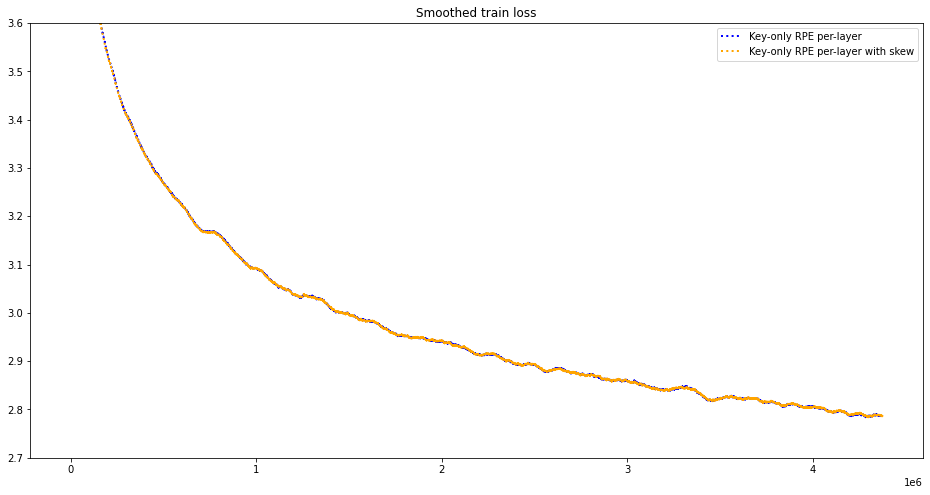

In [38]:
plt.figure(figsize=(16, 8))
window = 1000
plot_loss(loss_histories['rpe_konly_perlayer_n8_h8_d512_c64']['train_loss'],
          smooth_window=window,
          color='blue',
          linestyle=':',
          linewidth=2)
plot_loss(loss_histories['rpe_konly_perlayer_skew_n8_h8_d512_c64_v2']['train_loss'],
          smooth_window=window,
          color='orange',
          linestyle=':',
          linewidth=2)
plt.title('Smoothed train loss')
plt.legend([
    'Key-only RPE per-layer',
    'Key-only RPE per-layer with skew',
])
plt.ylim([2.7, 3.6])

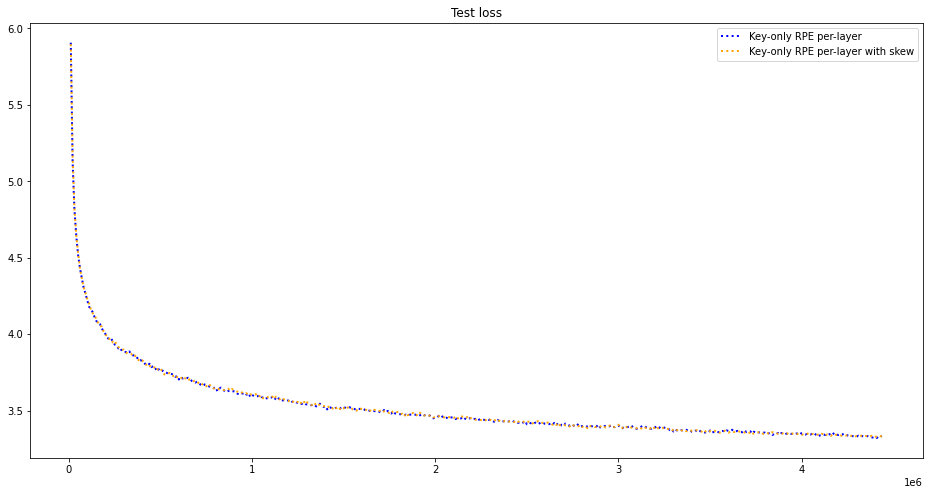

In [41]:
plt.figure(figsize=(16, 8))
plot_loss(loss_histories['rpe_konly_perlayer_n8_h8_d512_c64']['test_loss'],
          color='blue',
          linestyle=':',
          linewidth=2)
plot_loss(loss_histories['rpe_konly_perlayer_skew_n8_h8_d512_c64_v2']['test_loss'],
          color='orange',
          linestyle=':',
          linewidth=2)
plt.title('Test loss')
plt.legend([
    'Key-only RPE per-layer',
    'Key-only RPE per-layer with skew',
])
#plt.ylim([3.3, 4])